In [ ]:
#import tensorflow in saturn..etc

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
!wget data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2022-04-27 08:36:05--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2022-04-27 08:36:05--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  8.41MB/s    in 6m 53s  

2022-04-27 08:42:59 (8.15 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [5]:
!wget data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

--2022-04-27 08:43:00--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2022-04-27 08:43:01--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  12.3MB/s    in 36s     

2022-04-27 08:43:37 (11.9 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]



In [7]:
from zipfile import ZipFile
zf = ZipFile('DIV2K_train_HR.zip', 'r')
zf.extractall('images') # zip all image in folder images 
zf.close()

In [8]:
from zipfile import ZipFile
zf = ZipFile('DIV2K_valid_HR.zip', 'r')
zf.extractall('images') # zip all image in folder images 
zf.close()

In [5]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [6]:
root_dir= "DIV2K_train_HR" #path of div2k hr folder 
resize = 400
upscale_factor = 4
input_size = resize // upscale_factor
batch_size = 15

In [7]:
train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(resize, resize),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(resize, resize),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 900 files belonging to 1 classes.
Using 720 files for training.
Found 900 files belonging to 1 classes.
Using 180 files for validation.


2022-05-14 06:36:25.412878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-14 06:36:25.412911: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-14 06:36:25.412929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (w-tarek-testespcn-d091dcc2dc3246c6b4d6ba8b23f2e6b6-596b6772nvhh): /proc/driver/nvidia/version does not exist
2022-05-14 06:36:25.413178: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

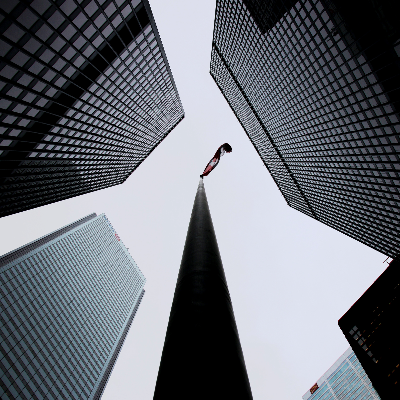

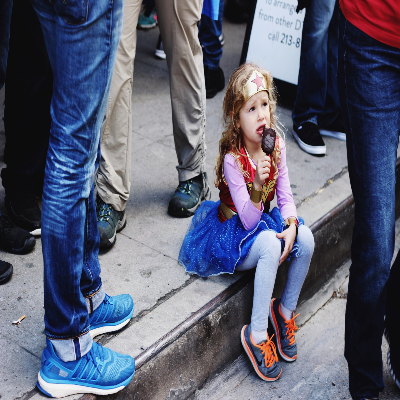

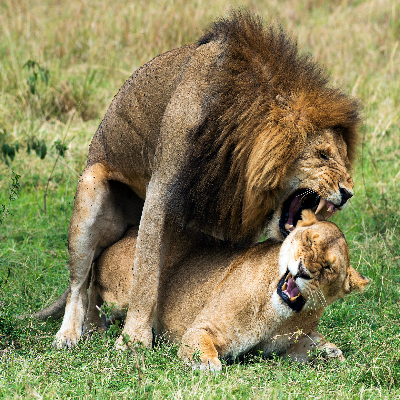

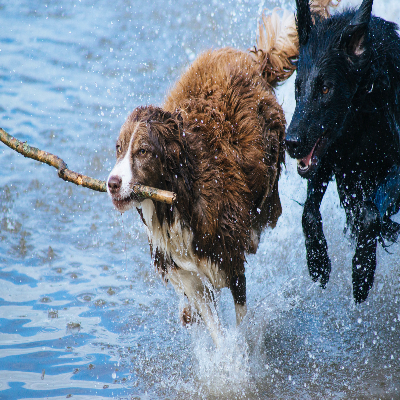

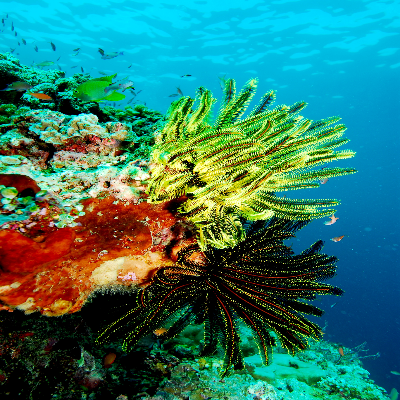

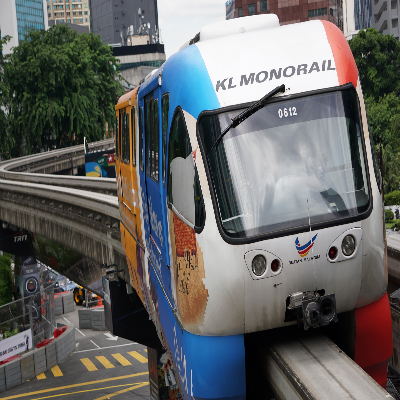

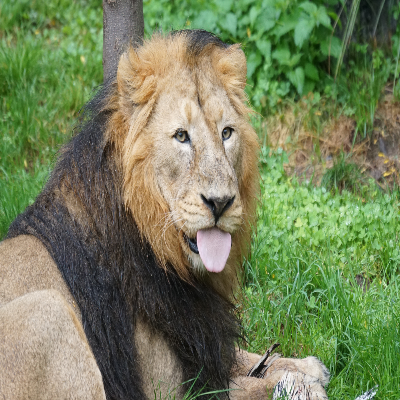

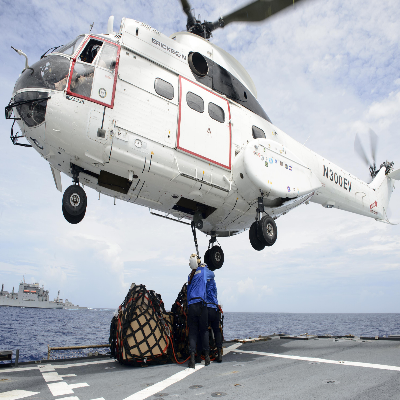

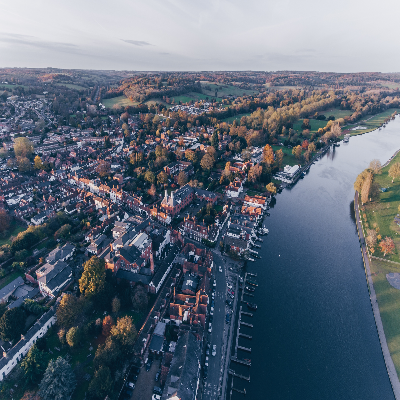

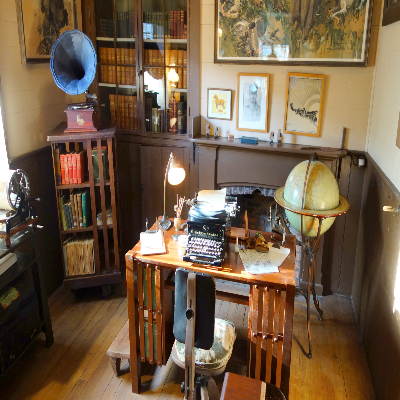

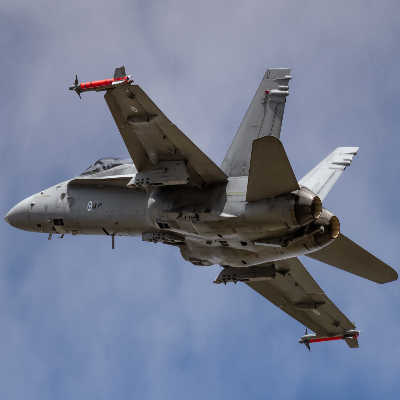

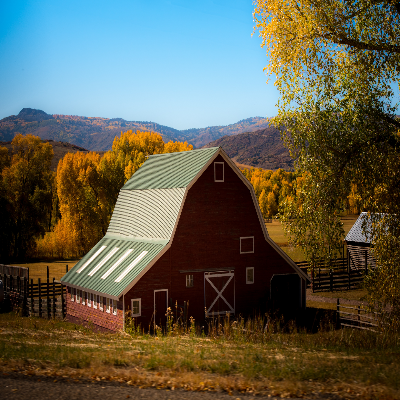

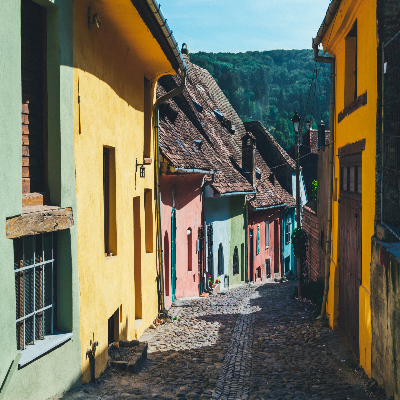

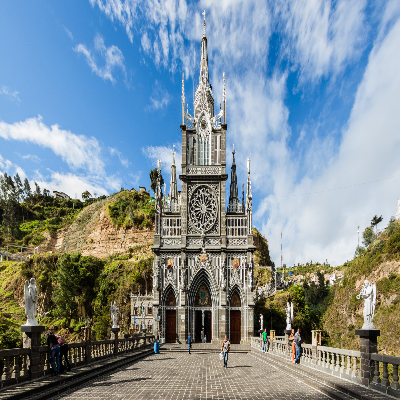

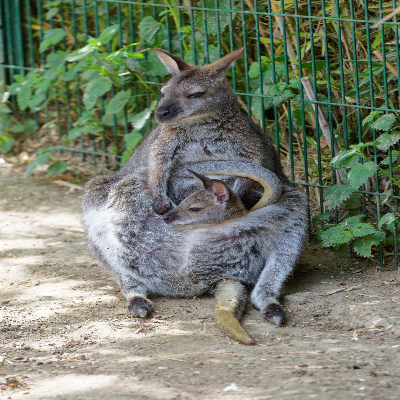

In [9]:
#to display random images in your training dataset 
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [10]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

print(train_ds) #output should be like that (it shows the input and output of the training)
#<PrefetchDataset shapes: ((None, 200, 200, 3), (None, 400, 400, 3)), types: (tf.float32, tf.float32)>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 400, 1), dtype=tf.float32, name=None))>


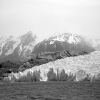

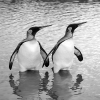

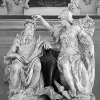

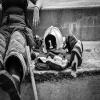

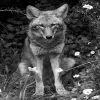

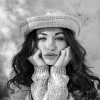

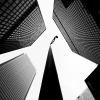

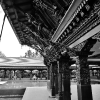

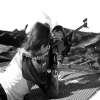

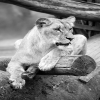

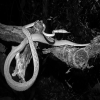

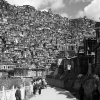

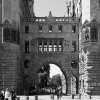

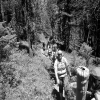

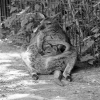

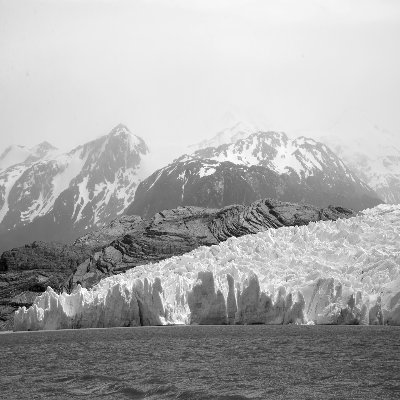

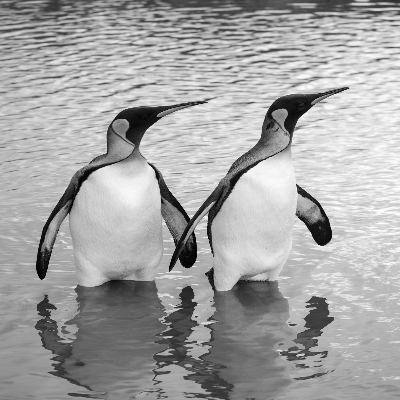

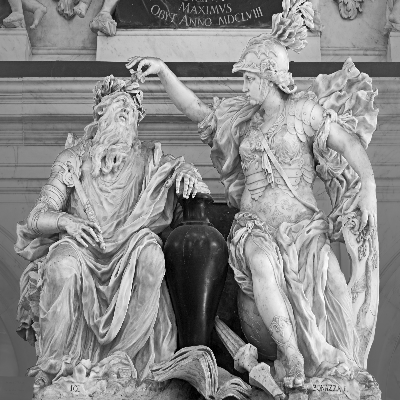

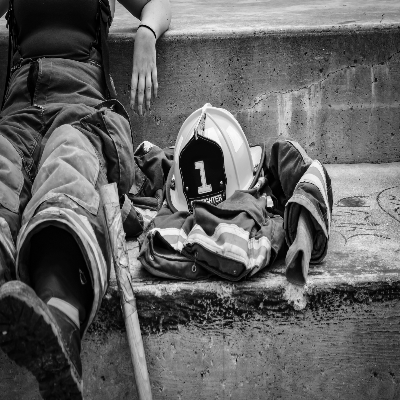

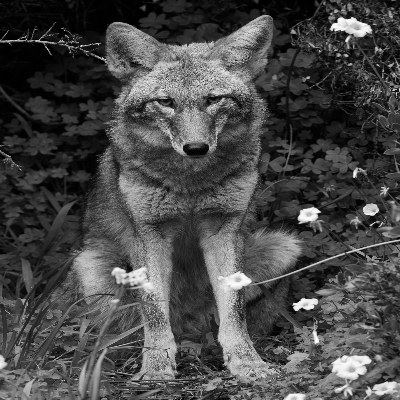

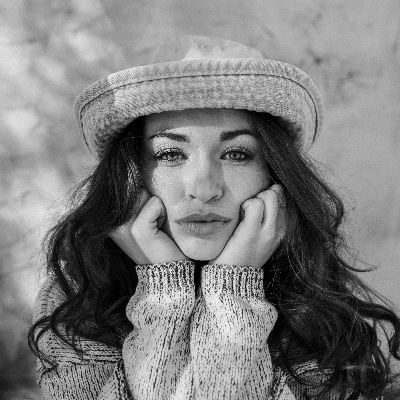

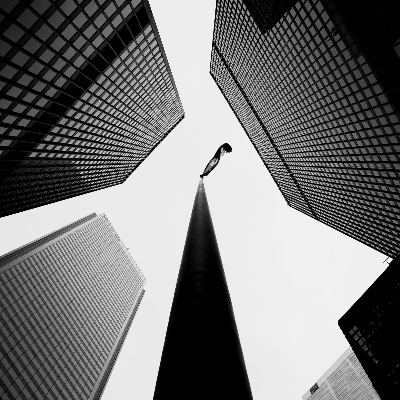

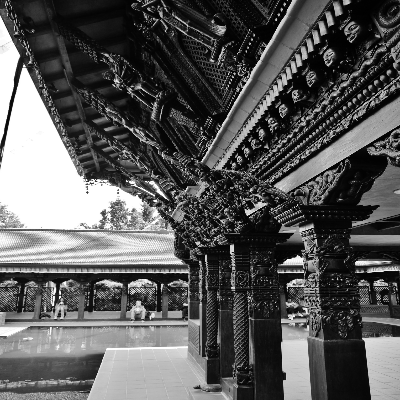

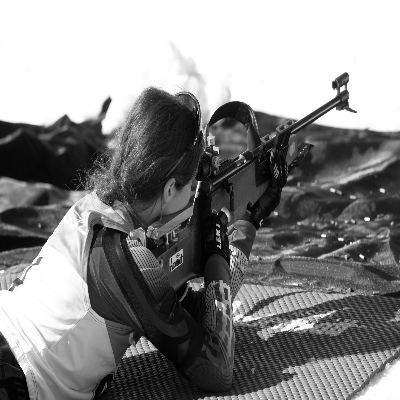

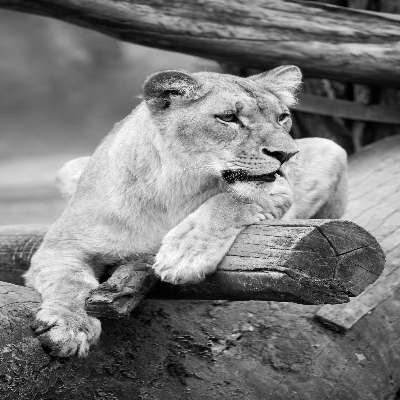

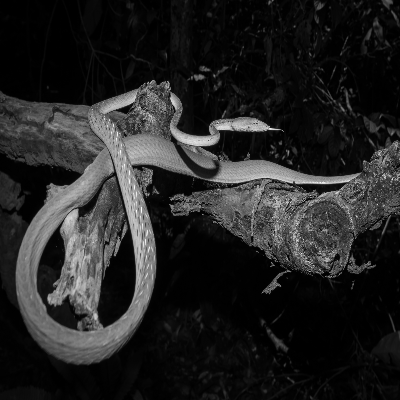

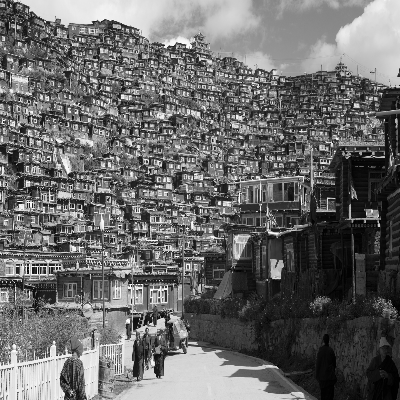

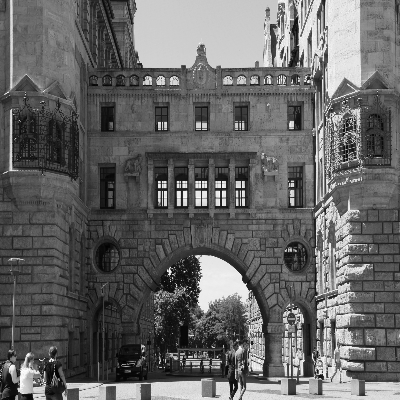

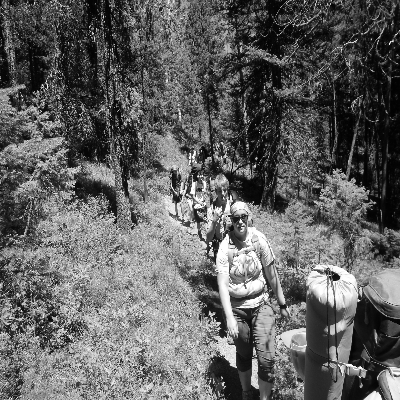

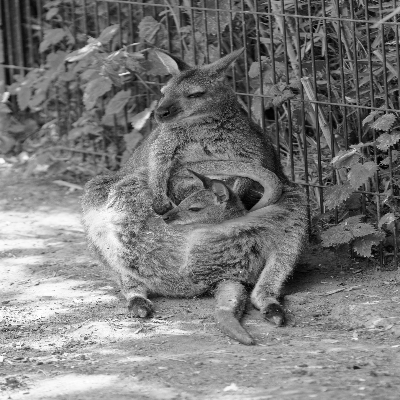

In [11]:
#to display the images in training before and after
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [12]:
#building model 
#Compared to the paper, they add one more layer and they used the relu activation function instead of tanh. 
#It achieves better performance even though we train the model for fewer epochs.
def get_model(upscale_factor=4, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [14]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "weights"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + '/x8.h5',
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

Mcallbacks = [early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
Moptimizer = keras.optimizers.Adam(learning_rate=0.001)

ep = 100

model.compile(
    optimizer=Moptimizer, loss=loss_fn, metrics = ['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

In [ ]:
history = model.fit(
    train_ds, epochs=ep, callbacks=Mcallbacks, validation_data=valid_ds, verbose=1
)
history

Epoch 1/100
48/48 [==============================] - 39s 755ms/step - loss: 0.0527 - accuracy: 0.0076 - val_loss: 0.0124 - val_accuracy: 0.0120
Epoch 2/100
48/48 [==============================] - 37s 717ms/step - loss: 0.0108 - accuracy: 0.0081 - val_loss: 0.0080 - val_accuracy: 0.0120
Epoch 3/100
48/48 [==============================] - 37s 718ms/step - loss: 0.0085 - accuracy: 0.0081 - val_loss: 0.0072 - val_accuracy: 0.0120
Epoch 4/100
48/48 [==============================] - 37s 720ms/step - loss: 0.0080 - accuracy: 0.0081 - val_loss: 0.0069 - val_accuracy: 0.0120
Epoch 5/100
48/48 [==============================] - 37s 718ms/step - loss: 0.0078 - accuracy: 0.0081 - val_loss: 0.0068 - val_accuracy: 0.0120
Epoch 6/100
48/48 [==============================] - 37s 720ms/step - loss: 0.0077 - accuracy: 0.0081 - val_loss: 0.0071 - val_accuracy: 0.0120
Epoch 7/100
48/48 [==============================] - 37s 717ms/step - loss: 0.0077 - accuracy: 0.0081 - val_loss: 0.0069 - val_accuracy:

In [ ]:
model.save('thenewx4.h5')

In [ ]:
 history.history

In [ ]:
loss = history.history['loss'] 

#plotting learning curve
epochs = range(1, len(loss) + 1)

#training and validation loss
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#trainig and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
ESPCN = tf.keras.models.load_model('new_weights_srcnn_model.h5') 

In [25]:
ESPCN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 4)     1156      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

In [8]:
import cv2
import sys
import glob
import time
import math
import argparse
import matplotlib.image as mpimg
from PIL import Image

In [16]:
#import low image
Lxmas = mpimg.imread('halfXmas.jpg')
Lxmas = Lxmas.astype(np.float32)/255

In [17]:
Lxmas = np.array(Lxmas)
Lxmas.shape

(971, 1734, 3)

In [18]:
Lxmas = [Lxmas]
Lxmas = np.array(Lxmas)
Lxmas.shape

(1, 971, 1734, 3)

In [19]:
#import ground image
xmas = mpimg.imread('Xmas.jpg')
xmas = xmas.astype(np.float32)/255

In [20]:
xmas = np.array(Lxmas)
xmas.shape


(1, 971, 1734, 3)

In [23]:
t0= time.time()
Hxmas = np.clip(ESPCN.predict(Lxmas), 0.0, 1.0)
t1 = time.time() - t0
print("Time elapsed: ", t1)

ValueError: in user code:

    File "/srv/conda/envs/saturn/lib/python3.10/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/srv/conda/envs/saturn/lib/python3.10/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/srv/conda/envs/saturn/lib/python3.10/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/srv/conda/envs/saturn/lib/python3.10/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/srv/conda/envs/saturn/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/srv/conda/envs/saturn/lib/python3.10/site-packages/keras/engine/input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model" (type Functional).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 971, 1734, 3)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 971, 1734, 3), dtype=float32)
      • training=False
      • mask=None


In [ ]:
plt.figure(figsize = (100, 100))
i = 1
plt.subplot(1,3,1)
plt.imshow(xmas[0])
plt.title("Ground Image")
i=2
plt.subplot(1,3,2)
plt.imshow(Lxmas[0])
plt.title("Low Resolution Image")
i=3
plt.subplot(1,3,3)
plt.imshow(Hxmas[0])
plt.title("High Resolution Image")

In [ ]:
from matplotlib.pyplot import imsave
#make folder x2sr to upload images in it
mpimg.imsave("MyDataSet/X2SR/ESPCNxmas.png", Hxmas[0])